## Sung Si-kyung vs Jang Beom-june

Here, we do not allow multiple entries from each ID.


In [5]:
import pandas as pd
import numpy as np
import re
import os
import sys

from google.colab import drive
drive.mount('/content/drive')

os.chdir("/content/drive/MyDrive/personal/Sentiment-Analyses/Sung_Si-kyung-vs-Jang_Beom-june/")
from A11_init_ import * # contains CLOVA id, secret key, url

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [74]:
## Load data
comments_df = pd.read_csv("./outputs/A10_comments_raw.csv")  # all comments
print(comments_df.shape)
comments_df.head(5)

(4136, 2)


,ID,comment
0,구름위로,그놈의 vs질 참 지겹다왕석현100명vs뱅갈호랑이1마리
1,민나상고멘,구름위로 이건 석현이 의견도 들어봐야..
2,괴해신살권,구름위로 김성찬150명 vs 왕석현100명
3,비정상인,2000년생 이상 급식은 장범준90년대생이하는 성시경 나올듯
4,래드키,비정상인 반대임ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ00년생은 성시경 80년생은 장범준인 분위기였음ㅋㅋ...


In [8]:
## Split sung's and jang's dfs using keywords for each artists.
## Keywords incldue: name, nickname, titles of top hit songs.

sung_keywords = ["시경", "성식", "거리에서", "두사람", "희재"] 
jang_keywords = ["범준", "버스커", "벚꽃", "여수", "노래방에서"]

sung_df = pd.DataFrame(columns = ["ID", "comments"])
jang_df = pd.DataFrame(columns = ["ID", "comments"])
neutral_df = pd.DataFrame(columns = ["ID", "comments"])

for idx_c in range(0, len(comments_df)):
    
    '''
    Each DF contains sentences that include any keyword for one artist, but no keyword for the other.
    If keywords from neither of the artists were included, then the sentence is stored in neutral_df.
    '''

    temp_id, temp_comment = comments_df.iloc[idx_c]
    
    if any(sk in temp_comment for sk in sung_keywords) == True and any(jk in temp_comment for jk in jang_keywords) == False:
        sung_df.loc[len(sung_df)] = [temp_id, temp_comment]
    elif any(jk in temp_comment for jk in jang_keywords) == True and any(sk in temp_comment for sk in sung_keywords) == False:
        jang_df.loc[len(jang_df)] = [temp_id, temp_comment]
    else:
        neutral_df.loc[len(neutral_df)] = [temp_id, temp_comment]

## save dfs
sung_df.to_csv("./outputs/B10_sung_df.csv", index = False)
jang_df.to_csv("./outputs/B10_jang_df.csv", index = False)
neutral_df.to_csv("./outputs/B10_neutral_df.csv", index = False)

In [64]:
print(sung_df.shape)
print(jang_df.shape)

## Remove multiple entries for each ID

sung_df2 = sung_df.drop_duplicates(subset = ["ID"], keep = "first").reset_index(drop = True)
jang_df2 = jang_df.drop_duplicates(subset = ["ID"], keep = "first").reset_index(drop = True)
print(sung_df2.shape)
print(jang_df2.shape)

## save dfs
sung_df2.to_csv("./outputs/B11_sung_df_remove_dups.csv", index = False)
jang_df2.to_csv("./outputs/B11_jang_df_remove_dups.csv", index = False)

## check 
sung_df2.head()

(720, 2)
(768, 2)
(312, 2)
(317, 2)


,ID,comments
0,비정상인,래드키 앵? 성시경 전성기를 모르는 애들이?
1,델카이저,래드키 이말이맞음 성시경이 00년대 goat 은 아니자너
2,클라우드22,래드키 니가 맞음. 성시경은 고트급인 발라더들은 거론할 것도 없고 김종국도 못이김.
3,Kaka#22.,비정상인 성시경이 요즘 유투브로 잘나가서 근데 이건 비교할거리도 안될정도로 성시경 ...
4,BEST 에펨트리,비정상인 전성기를 모르니깐 대충 들은 이야기 + 예능등에서 본 이미지로 가수를 평가...


In [ ]:
## Perform sentiment analysis using CLOVA Sentiment API

import sys
import requests
import json

client_id = clova_id
client_secret = clova_secret

url = clova_api_url

headers = {
    "X-NCP-APIGW-API-KEY-ID": client_id,
    "X-NCP-APIGW-API-KEY": client_secret,
    "Content-Type": "application/json"
}

dfs = ["sung_df", "jang_df"]

### Merge the comments into one document.
### Sentences are separated by "."

for df in dfs: # for each of sung and jang's data frame do:
    
    result_df = pd.DataFrame(columns = ["content", "sentiment", "negative", "neutral", "positive", "highlight"])

    # dat = "./outputs/B10_" + df + ".csv"
    dat = "./outputs/B11_" + df + "_remove_dups.csv"
    load_dat = pd.read_csv(dat)

    n = 0
    m = 999

    ## Merge lines to create a document. Lines are separated by "."
    document = ".".join(load_dat.comments)
    document = document + "."
    max_doc_length = len(document)

    while n < max_doc_length:
        
        m = m if m <= max_doc_length else max_doc_length
        
        content = document[n:m] # Cut number of lines to max 1000 words (Limit set by CLOVA Sentiment API)
        while content[-1] != ".":
            content = content[0:len(content)-1]  # cut the document upto last "."

        ### Run sentiment analysis
        data = {
            "content": content
        }

        # print(json.dumps(data, indent = 4, sort_keys = True))
        response = requests.post(url, data = json.dumps(data), headers = headers)
        rescode = response.status_code
        
        if (rescode == 200):
            print(response.text)
        else:
            print("Error : " + response.text)

        text = response.json()

        ## Extract features from results
        for i in range(0, len(text['sentences'])):
            c = text["sentences"][i]["content"]
            sent = text["sentences"][i]["sentiment"]
            sent_neg = text["sentences"][i]['confidence']['negative']
            sent_neu = text["sentences"][i]['confidence']['neutral']
            sent_pos = text["sentences"][i]['confidence']['positive']
            offset = text["sentences"][i]['highlights'][0]["offset"]
            length = text["sentences"][i]['highlights'][0]["length"]
            highlight = text['sentences'][i]["content"][offset: offset + length]

            result_df.loc[len(result_df), ] = [c, sent, sent_neg, sent_neu, sent_pos, highlight]

        ## set new start/end points for next set of words.
        n = n + len(content)
        m = n + 999 if n + 999 <= max_doc_length else max_doc_length

    out_name = "./outputs/C11_" + df + "_sentiments.csv"
    result_df.to_csv(out_name, index = False)

In [67]:
# Compute sentiment scores where sent_score = (positive / (positive + negative)) * 100

## Load the sentiment data from previous step.

sung_result = pd.read_csv("./outputs/C11_sung_df_sentiments.csv")
jang_result = pd.read_csv("./outputs/C11_jang_df_sentiments.csv")

## Compute and save the scores
scores_df = pd.DataFrame(columns = ["artist", "positive", "negative", "sent_score"])

sung_pos = sum(sung_result["positive"])
sung_neg = sum(sung_result["negative"])
sung_score = round(sung_pos / (sung_pos + sung_neg) * 100, 2)


jang_pos = sum(jang_result["positive"])
jang_neg = sum(jang_result["negative"])
jang_score = round(jang_pos / (jang_pos + jang_neg) * 100, 2)

scores_df.loc[0, ] = ["Sung Si-kyung", sung_pos, sung_neg, sung_score]
scores_df.loc[1, ] = ["Jang Beom-june", jang_pos, jang_neg, jang_score]
scores_df

## Jang has higher positive and negative scores.
## However, Sung's sent_score is higher than Jang's.

,artist,positive,negative,sent_score
0,Sung Si-kyung,79.025707,103.650868,43.26
1,Jang Beom-june,87.966038,135.578772,39.35


## Examples of positive sentiment comments

In [98]:
# For Sung Si-kyung:
sr1 = sung_result.loc[sung_result["sentiment"] == "positive", ].reset_index(drop = True)
idx = np.random.randint(low = 0, high = 50, size = 5)
sr1.iloc[idx, ]

,content,sentiment,negative,neutral,positive,highlight
23,둘중 한명 꼽으면 무조건 성시경인데.. 김나박이처럼 발성 짱짱한애들만 인정해주는 시...,positive,0.004694,0.012113,0.983194,김나박이처럼 발성 짱짱한애들만 인정해주는 시대에서도 살아남아서
31,가수는 가창력이지 닥 성시경.,positive,0.000581,0.000987,0.998432,가수는 가창력이지 닥 성시경
9,개소 추억보정이라고 하기에는보컬로서의 가창력이나 콘서트 관중동원력에서아직 장보다 성...,positive,0.003325,0.003951,0.992725,그 외부분에서 아직 성시경이 생각보다 쌩쌩함
6,성시경이 당연히 윈줄알았는데..95년생임 난 성시경 노래가 더 좋아.,positive,0.000577,0.000969,0.998453,성시경 노래가 더 좋아
22,내 취향은 성시경이긴 한데.. 콘서트 가봤는데 진짜 좋았음.,positive,0.000000,0.000000,1.000000,내 취향은 성시경이긴 한데


In [102]:
# For Jang Beom-june:
jr1 = jang_result.loc[jang_result["sentiment"] == "positive", ].reset_index(drop = True)
idx = np.random.randint(low = 0, high = 50, size = 5)
jr1.iloc[idx, ]

,content,sentiment,negative,neutral,positive,highlight
2,무협초보 당장 장범준이 원히트원더 어쩌고했지만 버스커버스커 1집은 음반자체가 명반이...,positive,0.001128,0.000587,0.998285,성적 괜찮았음
35,장범준이 직접 만들고 본인 창법으로 부른 노래들도 충분히 많은 사람들한테 사랑받았...,positive,0.000575,0.001563,0.997862,그것 때문에 비교되고
24,선사해 벚꽃엔딩 넘을 수 있는 곡은 가요계 통틀어도 몇 개 없을걸?.,positive,0.001509,0.026067,0.972424,선사해 벚꽃엔딩 넘을 수 있는 곡은 가요계 통틀어도 몇 개 없을걸
6,슈스케로 대박낸 원히터가수 정도로 생각했는데 평가가 많이 높았네.,positive,0.001056,0.000559,0.998386,평가가 많이 높았네
26,장범준 파급력은 진짜 어마어마하지 않나 전국민이 알만한 곡도 가지고있고.비내리는오...,positive,0.000600,0.001446,0.997954,장범준 파급력은 진짜 어마어마하지 않나 전국민이 알만한 곡도 가지고


## Generate word clouds

In [57]:
### Generate word clouds

# !pip install konlpy
from wordcloud import WordCloud
from konlpy.tag import Twitter
from collections import Counter
 

dfs = ["sung_df", "jang_df"]

for df in dfs:
    
    f_name = "./outputs/B11_" + df + "_remove_dups.csv"
    text = pd.read_csv(f_name)
    text = ".".join(text["comments"])
    
    twitter = Twitter()

    sentences_tag = []
    sentences_tag = twitter.pos(text) 

    noun_adj_list = []

    ## only takes tags that are classified as nouns and ajectives.
    for word, tag in sentences_tag:
        if tag in ['Noun' , 'Adjective']: 
            noun_adj_list.append(word)


    ## pick top 50 words that appear most often.
    counts = Counter(noun_adj_list)
    tags = counts.most_common(50) 

    ## create word cloud
    wc = WordCloud(font_path = "../NanumSquareRoundOTFEB.otf", background_color="white", max_font_size=60)
    cloud = wc.generate_from_frequencies(dict(tags))

    cloud_name = "./outputs/D11_" + df + "_wordcloud.jpg"

    cloud.to_file(cloud_name)

/usr/local/lib/python3.7/dist-packages/konlpy/tag/_okt.py:17: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


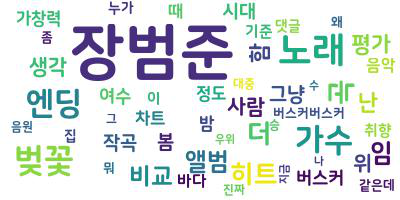

In [103]:
from PIL import Image
Image.open("./outputs/D11_sung_df_wordcloud.jpg")

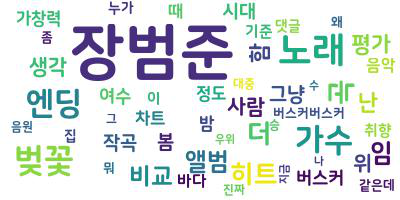

In [62]:
Image.open("./outputs/D11_jang_df_wordcloud.jpg")